# Functionality 2

First, we define shortest_path function, using the Dijkstra’s Algorithm: 

In [1]:
import trees as t
import math
from tqdm import tqdm
import numpy as np
import random
import networkx as nx

In [2]:
def shortest_path(graph, s, t):
    
    if s == t:
        return "There is no path, source and target nodes are the same", -1
    
    unvisited, shortest_path, predecessor= list(), dict(), dict()
    
    # We set the distances between the source node and all other nodes to infinity, except for the distance between source 
    # and itself, which we set to 0.
    for node in graph.nodes():
        shortest_path[node] = math.inf
        unvisited.append(node)
    shortest_path[s] = 0
    
    # We loop untile we visit all the nodes in the graph
    while unvisited:
        # We choose the node with the smallest value as the “current node”
        current_node = None
        for node in unvisited: 
            if current_node == None:
                current_node = node
            if shortest_path[node] <= shortest_path[current_node]:
                current_node = node
                
        if current_node == t:
            break
        # visit all the  neighbour of current_node. As we visit each neighbor, we update their tentative distance 
        # from the starting node
        for neighbor in graph.neighbors(current_node):
            value = shortest_path[current_node] + graph[current_node][neighbor]['weight']
            if value < shortest_path[neighbor]:
                shortest_path[neighbor] = value
                predecessor[neighbor] = current_node
        unvisited.remove(current_node)
    
    if t not in predecessor:
        return "Not possible, there is no path between target and source", -1
    # now we have to return the path using predecessor dictionary
    
    last = t
    path = list([last])
    while last != s:
        path.append(predecessor[last])
        last = predecessor[last]
    
    return path, shortest_path[t]  

### Betweenness centrality
Let $n_{s,t}^{v}$ be the number of shortest paths from $s$ to $t$ that pass through $v$ and let $n_{s,t}$ be the total number of shortest paths from $s$ to $t$. Then the betweenness centrality of node $v$ is:

$\displaystyle{B(v) = \sum_{s, t} \frac{n_{s,t}^{v}}{n_{s,t}}}$

In [3]:
def betweenness(v, graph):
    num, den = 0, 0
    
    #for each node we compute the shortest path with all the other nodes in the graph
    for source in tqdm(graph.nodes()):
        for target in graph.nodes():
            if source != target and source != v and target != v:
                path, dist = shortest_path(graph, source, target)
                # if exist a shortest path between the source and the target, we update the denominator
                if dist != -1:
                    den += 1
                    # if the node in input is in the shortest path then we update the numerator
                    if v in path:
                        num += 1
    # we change the value of the denominator if it's equal to 0, to avoid dividing by zero                   
    if den == 0:
        den = 1
    betweenness_centrality = num/den
    return betweenness_centrality          

### Closeness centrality
$C(v)={\frac  {N-1}{\sum _{u}d(u,v)}}$
- N is the number of total nodes in the graph
- $d(u,v)$ is the distance between the nodes u and v

In [4]:
def closeness(v, graph):
    N = len(graph.nodes())
    count = 0
   # for each node in the graph we calculate the distance between this node and the node in input
    for node in tqdm(graph.nodes()):
        path, dist = shortest_path(graph, v, node)
        # if exist a path between the node in input v and "node" then we update the count of the distances
        if dist != -1:
            count += dist
    if count == 0:
        return "There is no path between the node in input and all other nodes in the graph!"
    
    closeness_centrality = (N - 1) / count
    return closeness_centrality

### Degree Centrality

$D(v)={\frac  {degree(v)}{N-1}}$

In [5]:
def degree_centrality(v, graph):
    N = len(graph.nodes())
    out_degree = 0
    in_degree = 0
    for (i,j) in graph.edges():
        # for each edge in the graph we collect the number of outgoing edges from v
        if i == v:
            out_degree += 1
        # for each edge in the graph we collect the number of ingoing edges in v
        if j == v:
            in_degree += 1
    # the degree of a node is given by the sum of the in-degree and out-degree of the node
    degree = in_degree + out_degree
    degree_centrality = degree / (N-1)
    return degree_centrality

### Page rank
First we create the matrix P using this formula:
<p>$P={(1 - \alpha) * M + \alpha*P_{rw}}$<p>
<p> - $N$ is the number of nodes in the graph<p>
<p> - $M$ is a matrix $N*N$ with all components equal to $\frac{1}{N}$<p>
<p> - $P_{rw}$ is a matrix $N*N$ in which the components $a_{i,j}$ ,such that exist an edge between the node relative to $i$ row and the node relative to $j$ column, are given by the normalized weight of the edge. The nodes that do not have any outgoing edge, are such that their corresponding row in $P_{rw}$ has all columns equal to $\frac{1}{N}$<p>

In [6]:
def create_matrix_P(graph, alpha):
    
    N = len(graph.nodes())
    # to make the graph stochastic
    graph = nx.stochastic_graph(graph, weight='weight')
    
    # initialize P_rw and M matrix
    P_rw = np.zeros([N,N])
    M = np.full([N,N], 1/N)
    
    # for each node in the graph, we define and memorize its position number in order to build the P_rw matrix
    pos = dict()
    count_pos = 0
    for node in graph.nodes():
        pos[node] = count_pos
        count_pos += 1
    
    # for each node we see the edges that exit from this node
    for node in pos:
        col = list()
        for (i,j) in graph.edges():
        # for each node we collect the node in which each edge goes
            if node == i:
                col.append(j)
        # then we update the component relative to "node" and "elem" of the P_rw matrix 
        for elem in col:
            P_rw[pos[node]][pos[elem]] = graph[node][elem]["weight"]
    
    # if the outdegree of a node is equal to 0, so the node is an "autorithy", the relative components of P_rw are equal to 1/N
    for node in pos:
        if np.sum(P_rw[pos[node]]) == 0:
            P_rw[pos[node]] = np.full([1,N], 1/N)
            
    # finally we build the matrix P
    P = ((1 - alpha) * M) + (alpha * P_rw)

    return P, pos    

Then, we compute the pagerank algorithm:
- We start from select at random a starting node;
- Then we initialize the $q_0$ vector, such that all of his components are equal to 0, except for the component relative to the starting node, which is equal to 1;
- for each step $t$ of the algorithm we compute: $q_{t} = q_{t-1} * P$ and we check if the algorithm converges;
- if the algorithm have converged we return the number of iterations needed and the page rank value relative to the node $v$ in input.

In [7]:
def pagerank_score(v, graph, alpha, max_iter, tol):
    
    N = len(graph.nodes())
    P, pos = create_matrix_P(graph, alpha)
    
    if v not in graph.nodes():
        return "the node in input should be in the time interval graph"
    
    # picking the start position at random
    random.seed(123)
    start_pos = random.randint(0, N)
    
    # find the position of the node in input using pos dictionary, we will use this position after when returning the pr
    for key, value in pos.items():
        if key == v:
            input_node_pos = value
    
    # initialize the vector q such that there are all zeros except a one in the start_position
    q_start = np.zeros(N)
    q_start[start_pos] = 1
    
    #keep track of the convergence of the algorithm
    convergence = False
    
    for step in tqdm(range(max_iter)):
        # for every step we compute q_t = q_(t-1) * P
        q_t = np.dot(q_start, P)
        # calculate the error in order to check the convergence
        err = sum([abs(q_t[i] - q_start[i]) for i in range(len(q_t))])
        if err < N * tol:
            print("the algorithm Page rank converges in ", step, "iterations")
            return q_t[input_node_pos]
        # update the vector q_start 
        q_start = q_t
        
    if convergence == False:
        print("The algorithm did not converge for ", max_iter, "number of iterations")
    
    return q_t[input_node_pos]

Let's now define the functionality 2 that takes in input <p>
<p> - A user/node <p>
<p> - An interval of time <p>
<p> - One of the following metrics: Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality <p>
The output is the value of the given metric applied over the complete graph for the given interval of time.

Note that we have used a different interval for the print of the betweenness because the running time of this metric is high, so we search for a time interval with maximum 100 nodes. Instead for the other metrics, we used a different time interval with 1500 nodes.

In [8]:
def functionality_2(v, start_interval, end_interval, metric, alpha=None, max_iter=None, tol = None):
    graph = t.build("a", start_interval, end_interval)
    if metric == "Betweeness":
        return betweenness(v, graph)
    elif metric == "PageRank" and alpha != None and max_iter != None and tol != None:
        return pagerank_score(v, graph, alpha, max_iter, tol)
    elif metric == "ClosenessCentrality":
        return closeness(v, graph)
    elif metric == "DegreeCentrality":
        return degree_centrality(v, graph)

In [9]:
# show the functionality two with betweenness metric
print(functionality_2(49, "2008-08-01", "2008-08-04", "Betweeness"))

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.46it/s]

0.1268472906403941


In [10]:
# show the functionality two with closeness metric
print(functionality_2(3347, "2008-09-01", "2008-09-06", "ClosenessCentrality"))

100%|██████████████████████████████████████████████████████████████████████████████| 1523/1523 [03:05<00:00,  8.21it/s]

0.25822870715982355


In [11]:
# show the functionality two with pagerank metric
print(functionality_2(3347, "2008-09-01", "2008-09-06", "PageRank", alpha=0.85, max_iter=100, tol = 0.000001))

 12%|█████████▌                                                                      | 12/100 [00:00<00:00, 138.36it/s]

the algorithm Page rank converges in  12 iterations
0.0010742618150226676


In [12]:
# show the functionality two with degree centrality metric
print(functionality_2(3347, "2008-09-01", "2008-09-06", "DegreeCentrality"))

0.01445466491458607


# Visualization 2
- Plot the input node and a subset of its neighbouring nodes such that the user can get a grasp of the importance of this input node. 
- Split the interval of time into equidistant ranges of time and show the metric evolution over time.

In [13]:
import matplotlib.pyplot as plt

In [18]:
def visualization_2(v, start_interval, end_interval):
    graph = t.build("a", start_interval, end_interval)
    g = nx.DiGraph()
    # building a graph with only the neighbors of the node in input
    for neighbor in graph.neighbors(v):
        g.add_edge(v, neighbor, weight = graph[v][neighbor]["weight"])
    nx.draw(g, node_color="green", edge_color = "gray", node_size = 1000, width=1.5, with_labels=True)
    return plt.show(g)

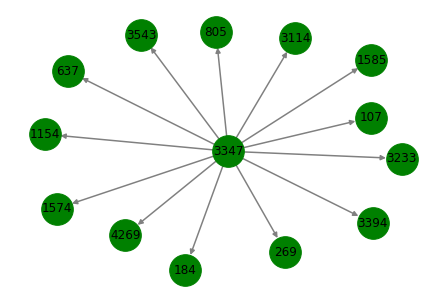

None


In [19]:
# visualization of the importance of node 3347 used for the prints of the closeness, pagerank and degree scores
print(visualization_2(3347, "2008-09-01", "2008-09-06"))

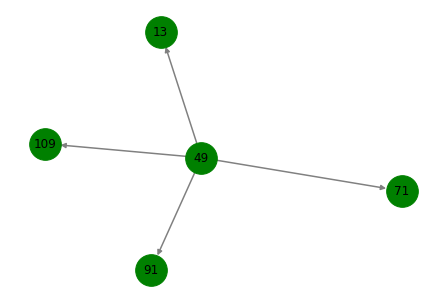

None


In [20]:
# visualization of the importance of node 49 used for the prints of the betweennes
print(visualization_2(49, "2008-08-01", "2008-08-04"))

### Evolution of the Page rank and DegreeCentrality
- We split the interval from 1-09-2008 to 06-09-2008 into 3 intervals of two days each.
- We can see that the user 3347 has more pagerank score and degree centrality score in the second interval (3-4 september 2008)
- In addition, the user 3347 has smallest pagerank score in the third interval, and differently has the smallest degree score in the first interval

 11%|████████▋                                                                      | 11/100 [00:00<00:00, 1379.00it/s]


the algorithm Page rank converges in  11 iterations


 20%|███████████████▊                                                               | 20/100 [00:00<00:00, 1253.12it/s]


the algorithm Page rank converges in  20 iterations


 10%|████████                                                                        | 10/100 [00:00<00:00, 999.14it/s]

the algorithm Page rank converges in  10 iterations
0.0014757649433330003  is the value of the Pagerank for 1-2 settembre 2008
0.0031540943459822997  is the value of the Pagerank for 3-4 settembre 2008
0.0007977482829770688  is the value of the Pagerank for 5-6 settembre 2008


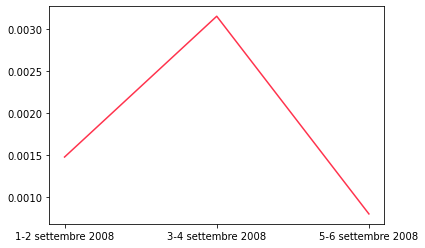

In [21]:
y = list()
i = functionality_2(3347, "2008-09-01", "2008-09-02", "PageRank", alpha=0.85, max_iter=100, tol = 0.000001)
j = functionality_2(3347, "2008-09-03", "2008-09-04", "PageRank", alpha=0.85, max_iter=100, tol = 0.000001)
z = functionality_2(3347, "2008-09-05", "2008-09-06", "PageRank", alpha=0.85, max_iter=100, tol = 0.000001)

y.append(i)
y.append(j)
y.append(z)

print(i, " is the value of the Pagerank for 1-2 settembre 2008")
print(j, " is the value of the Pagerank for 3-4 settembre 2008")
print(z, " is the value of the Pagerank for 5-6 settembre 2008")


fig = plt.figure()
ax = plt.axes()

x = ["1-2 settembre 2008", "3-4 settembre 2008", "5-6 settembre 2008"]
ax.plot(x, y, color = (1.0,0.2,0.3));

0.0024330900243309003  is the value of the DegreeCentrality for 1-2 settembre 2008
0.016793893129770993  is the value of the DegreeCentrality for 3-4 settembre 2008
0.0046801872074883  is the value of the DegreeCentrality for 5-6 settembre 2008


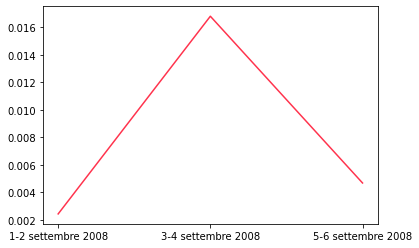

In [22]:
y = list()
i = functionality_2(3347, "2008-09-01", "2008-09-02", "DegreeCentrality")
j = functionality_2(3347, "2008-09-03", "2008-09-04", "DegreeCentrality")
z = functionality_2(3347, "2008-09-05", "2008-09-06", "DegreeCentrality")

y.append(i)
y.append(j)
y.append(z)

print(i, " is the value of the DegreeCentrality for 1-2 settembre 2008")
print(j, " is the value of the DegreeCentrality for 3-4 settembre 2008")
print(z, " is the value of the DegreeCentrality for 5-6 settembre 2008")


fig = plt.figure()
ax = plt.axes()

x = ["1-2 settembre 2008", "3-4 settembre 2008", "5-6 settembre 2008"]
ax.plot(x, y, color = (1.0,0.2,0.3));